In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import data_rnn as dat

(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = dat.load_imdb(final=False)

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [21]:
batch_size = 100

batched_x = []
batched_y = []
for i in range(0, len(x_train), batch_size):
    batch_x = x_train[i:i+batch_size]
    batch_y = y_train[i:i+batch_size]
    max_len = max([len(x) for x in batch_x])
    batch_x = [ x + [0] * (max_len - len(x)) for x in batch_x] # padding
    
    batched_x.append(torch.tensor(batch_x,dtype=torch.long))
    batched_y.append(torch.tensor(batch_y,dtype=torch.long))


batched_x_val = []
batched_y_val = []
for i in range(0, len(x_val), batch_size):
    batch_x = x_val[i:i+batch_size]
    batch_y = y_val[i:i+batch_size]
    max_len = max([len(x) for x in batch_x])
    batch_x = [ x + [0] * (max_len - len(x)) for x in batch_x] # padding
    
    batched_x_val.append(torch.tensor(batch_x,dtype=torch.long))
    batched_y_val.append(torch.tensor(batch_y,dtype=torch.long))

PART 2

In [22]:
dictionary_size = len(i2w)
embedding_size = 300
hidden_size = 300
epochs = 10
learning_rate = 0.001
momentum = 0.9

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(dictionary_size, embedding_size, padding_idx=0)
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)
        
    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.fc1(x))
        x = torch.max(x,1).values
        x = self.fc2(x)
        return x

In [24]:
import time 

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
def train(net):
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    running_loss = []
    train_acc_per_epoch = []
    val_acc_per_epoch = []


    for epoch in range(epochs):
        train_losses = []
        start_time = time.time()
        correct = 0
        total = 0
        for inputs, labels in zip(batched_x, batched_y):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            #print(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
            running_loss.append(loss.item())
        train_acc_per_epoch.append(correct / total)
        train_acc = correct / total
        correct = 0
        total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs    
        with torch.no_grad():
            for inputs, labels in zip(batched_x_val, batched_y_val):
                # calculate outputs by running images through the network 
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                #print(predicted, labels)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        
        val_acc_per_epoch.append(correct / total)
        vall_acc = correct / total
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        epoch_train_loss = np.mean(train_losses)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'train_loss : {epoch_train_loss}')
        print(f'train_accuracy : {train_acc*100} val_accuracy : {vall_acc*100}')
        print(25*'==')

    return running_loss, train_acc_per_epoch, val_acc_per_epoch

In [26]:
net = Net()
#moving to gpu
net.to(device)
print(net)
running_loss_MLP, train_acc_per_epoch_MLP, val_acc_per_epoch_MLP = train(net)

Net(
  (embedding): Embedding(99430, 300, padding_idx=0)
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
)
Epoch: 01 | Epoch Time: 2m 31s
train_loss : 0.4170842108130455
train_accuracy : 80.345 val_accuracy : 86.04
Epoch: 02 | Epoch Time: 2m 9s
train_loss : 0.26446823246777057
train_accuracy : 89.41 val_accuracy : 87.3
Epoch: 03 | Epoch Time: 2m 29s
train_loss : 0.18865508254617452
train_accuracy : 93.325 val_accuracy : 86.9
Epoch: 04 | Epoch Time: 2m 5s
train_loss : 0.12933364026248456
train_accuracy : 96.055 val_accuracy : 85.2
Epoch: 05 | Epoch Time: 2m 0s
train_loss : 0.09215282756835222
train_accuracy : 97.36 val_accuracy : 75.84
Epoch: 06 | Epoch Time: 2m 21s
train_loss : 0.07870690372306853
train_accuracy : 97.24000000000001 val_accuracy : 88.08
Epoch: 07 | Epoch Time: 2m 13s
train_loss : 0.0607642090274021
train_accuracy : 97.935 val_accuracy : 81.47999999999999
Epoch: 08 | Epoch Time: 2m 33s
train_loss :

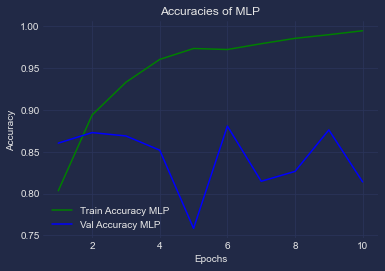

In [27]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey
epochs_range = np.arange(1,epochs+1)
plt.plot(epochs_range, train_acc_per_epoch_MLP, 'g', label='Train Accuracy MLP')
plt.plot(epochs_range, val_acc_per_epoch_MLP, 'b', label='Val Accuracy MLP')
#plt.plot(epochs_range, relu_acc, 'b', label='ReLU Accuracy')
plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background
plt.title('Accuracies of MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
